# **Apogee Data Pipeline** - Scaled

In [19]:
# Allow imports from parent directory - robust incase run twice 
import os, sys
if os.path.basename(os.getcwd()) == "notebooks":
    os.chdir("..")
    sys.path.append(os.path.abspath(".")) 

# Imports for this notebook 
from analysis import XDPipeline
from astropy.table import Table

In [ ]:
# Set true to rerun XD analysis - approx 10 hours for 100 iterations with 3 repeats (300) per gaussian component
# This will overwrite any previous XD analysis unless the file name is changed
# If rerun, the clusters will be determined from random initialisations so the `color palattes` and `labels` in the table and graphs will need correcting
rerun_XD = False


# This is whether the full plotting datafile for the background has been obtained from the Google Drive
plot_background = False

# Set background option
if plot_background:
    background = 'data/raw/Total_Apogee/ApogeeDR17_backgroundplots.fits'
else:
    background = None


## **Importing/ Filtering Apogee Data**
- First data is imported according to the cuts outlined in `0_data_distribution`

In [21]:
apogee_data_filtered_path = 'data/filtered/Apogee/Apogee_data_filtered_1612.fits'

In [22]:
# Open from file into astropy Table
apogee_processed_data = Table.read(apogee_data_filtered_path, format='fits')

## **XD Pipeline**
- The XD pipeline contains the following processes and functionalities


### **`run_XD()` – Extreme Deconvolution Summary**

This method applies **Extreme Deconvolution (XD)** to model stellar data, accounting for measurement uncertainties directly in the fit.

* Searches over a range of Gaussian components (`gauss_component_range`), with multiple **initialisations** (`n_init`) and **repeats** (`n_repeats`).
* Optionally applies **feature scaling** (`scaling=True`) using `StandardScaler` to improve numerical stability.
* Means and covariances are automatically rescaled to their original units after fitting.
* For each run (defined by the number of Gaussian components, initialisation, and repeat), the following results are stored:
    * `log_likelihood`: Log-likelihood of the fit.
    * `BIC`: Bayesian Information Criterion.
    * `AIC`: Akaike Information Criterion.
    * `weights`: Component weights.
    * `means`: Component means (rescaled if scaling was applied).
    * `covariances`: Component covariances (rescaled if scaling was applied).

In [23]:
?XDPipeline

Init signature:
XDPipeline(
    star_data: Union[astropy.table.table.Table, numpy.rec.recarray, pandas.core.frame.DataFrame],
    data_keys: List[str],
    data_err_keys: List[str],
    scaling: bool = True,
)
Docstring:     
A pipeline for performing Extreme Deconvolution (XD) using a Gaussian Mixture Model (GMM).

Aims at analysing and fitting multi-dimensional stellar datasets.

The pipeline follows these key steps:

1. **Initialisation** (`__init__`):

   - Takes in stellar data as an Astropy Table, NumPy recarray, or Pandas DataFrame.
   - Extracts relevant features defined by `data_keys` and their errors `data_err_keys`.

2. **Extreme Deconvolution (XD)** (`run_XD`):

   - Normalises the dataset for efficient convergence. (Optional: scaling)
   - Runs XD over a specified range of Gaussian components.
   - Iterates through multiple random initialisations to ensure robust fitting.
   - Uses BIC and AIC scores to evaluate model performance.
   - Optionally saves results to a file fo

### **Initialisation of Pipeline**
- Imports revelent total data set and the keys for the data features (and corrosponding errors of intrest)

In [24]:
apogee_data_keys = ['fe_h', 'alpha_m', 'E_50', 'ce_fe', 'al_fe', 'mg_mn']
apogee_data_error_keys = ['fe_h_err', 'alpha_m_err', 'E_err', 'ce_fe_err', 'al_fe_err', 'mg_mn_err']

apogee_pipeline = XDPipeline(apogee_processed_data, apogee_data_keys, apogee_data_error_keys)

### **XD Run Overview**  

#### **Parameters**  

| **Parameter**                     | **Value**  |
|------------------------------------|------------|
| **Max EM Iterations**              | \(10^9\)   |
| **Number of Gaussian Components**  | 0 – 10     |
| **Repeats per Gaussian Component** | 3          |
| **Initializations per Repeat**     | 100        |

#### **Stored Data**  
- Achieved Weights, Means, and Covariances for each run  
- Model Evaluation Metrics:  
  - AIC (Akaike Information Criterion)
  - BIC (Bayesian Information Criterion)

In [25]:
?XDPipeline.run_XD

Signature:
XDPipeline.run_XD(
    self,
    gauss_component_range: Tuple[int, int] = (1, 10),
    max_iterations: int = 1000000000,
    n_repeats: int = 3,
    n_init: int = 100,
    save_path: Optional[str] = None,
    timings: Optional[bool] = None,
)
Docstring:
Initialise the XDPipeline with stellar data and define the parameter space for 
Extreme Deconvolution (XD) using a specified set of features and their uncertainties.

This constructor supports optional scaling of features using standardisation. If 
`scaling=False`, the features are used in their original units; however, energy-related 
parameters ('E_50' or 'Energy') are manually scaled by 1e5 for consistency.

Parameters
----------
star_data : Table, np.recarray, or pd.DataFrame
    Input dataset containing stellar properties. Accepted formats are Astropy Table,
    NumPy recarray, or Pandas DataFrame.

data_keys : List[str]
    Column names representing the features to be used in the GMM-XD analysis.

data_err_keys : List[s

In [26]:
if rerun_XD:
    apogee_pipeline.run_XD(gauss_component_range=(1,10), max_iterations=int(1e9), n_repeats=3, n_init=100, save_path='XD_Results/Apogee/apogee_XD_2_3_23.pkl')

### **Run Results Analysis** 

#### **Overall**

| **Overall Results Analysis**                        | **Details** |
|---------------------------------|------------|
| **Performance Metric**          | BIC Score |
| **Filters Applied**             | None |
| **Saves**                       | Gaussian Weights, Means, and Covariances |
| **Records**                     | Corresponding BIC score |

#### **Filtered**

| **Filtered Results Analysis**   | **Details** |
|---------------------------------|------------|
| **Performance Metric**          | BIC Score |
| **Filters Applied**             | 5,6,7 Gaussian Components |
| **Saves**                       | Gaussian Weights, Means, and Covariances |
| **Records**                     | Corresponding BIC score |


In [27]:
?XDPipeline.compare_XD

Signature:
XDPipeline.compare_XD(
    self,
    opt_metric='BIC',
    n_gauss_filter: Optional[int] = None,
    repeat_no_filter: Optional[int] = None,
    save_path: Optional[str] = None,
    zoom_in: Optional[List[int]] = None,
    display_full: bool = True,
) -> None
Docstring:
Analyse Extreme Deconvolution (XD) results using BIC or AIC.
This method identifies the best-fit model, summarizes failed runs, and visualizes score distributions.
If no filters are applied, the analysis is performed on all results. Otherwise, it is performed on filtered results.

Parameters
----------
opt_metric : str
    Optimization metric ('BIC' or 'AIC').
n_gauss_filter : Optional[int]
    Specific number of Gaussian components to filter results by.
repeat_no_filter : Optional[int]
    Specific repeat cycle to filter results by.
save_path : Optional[str]
    Path to load XD results if not already stored in the class.

Raises
------
ValueError
    If results are not available in the class and no valid `sa

 Best Overall BIC Score: 20257.9314 occurred at:
   - Gaussian Components (n_gauss): 5
   - Repeat cycle (n): 2
   - Initialisation (i): 7
 The following filters were applied: {'n_gauss': 7, 'repeat': None}
 Best BIC Score from filtered inputs: 20337.4275 occurred at:
   - Gaussian Components (n_gauss): 7
   - Repeat cycle (n): 2
   - Initialisation (i): 73
Table of Number of Gaussians vs Number of Failed XD Runs
+----+-----------------+----------------------+------------------+
|    |   No. Gaussians |   No. Failed XD runs |   Total No. Runs |
|----+-----------------+----------------------+------------------|
|  0 |               1 |                    0 |              300 |
|  1 |               2 |                    0 |              300 |
|  2 |               3 |                    0 |              300 |
|  3 |               4 |                    0 |              300 |
|  4 |               5 |                    0 |              300 |
|  5 |               6 |                    0 |

/Users/jacobtutt/Desktop/MPhil_DIS/Project/analysis/XD.py:714: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


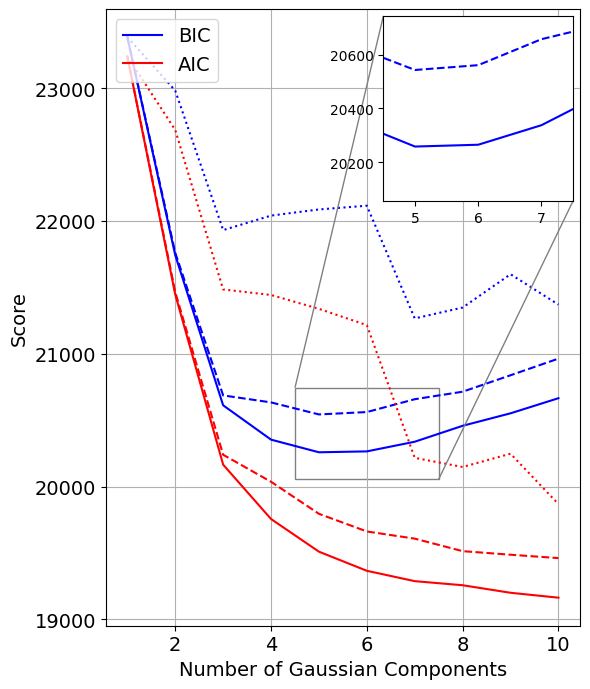

In [28]:
apogee_pipeline.compare_XD(opt_metric = 'BIC', n_gauss_filter = 7, repeat_no_filter = None, save_path='XD_Results/Apogee/apogee_XD_2_3_23.pkl', zoom_in=[5,6,7])

### **'Best Results': 5 Gaussian Components**
- However AIC and BIC only provides a rough indication of model comparison, not definite.
- We see that the following gaussian components all contain similiar results:
    - 5 , 6 , 7 and thus they are investigated indepedently to cross reference them with documented halo substructures to understand the physical meaning behind what has been identified

### An Overview of Results
- We show that they have identified the following:

| **No. Gaussian Componentss**   | **GS/E** | **Splash** | **Aurora** | **Eos** | **Background** | 
|---------------------------------|---------|---------|------------|------------|------------|
| **5 Components**          | 2 | 1| 0 | 1 | 1 | 
| **6 Components**          | 2 | 1| 1 | 1 | 1 | 
| **7 Components**          | 2 | 1| 1 | 1 | 2 | 

- This shows that the Aurora Popultation is the most weakly defined by the GMM (first to be `lost`). 
- Later supported by the representation in lower dimensional space, we see it is difficult to distinguish between the lower metalicity alpha plataeu of the GS/E and the high metalicty splash.


## **Determine Responsibilities and Assignment**

This step assigns each star to the most likely Gaussian component in the best-fit Extreme Deconvolution (XD) model by calculating *responsibilities*—the probabilities of membership in each component.

**Key operations include:**

* **Feature Scaling:** If applied during model fitting, `StandardScaler` is used to transform both the data and model parameters back into the same scaled space for consistency.
* **Error-Aware Covariances:** Each star’s measurement uncertainties are added to the intrinsic covariance of each Gaussian component, ensuring the model accounts for observational errors.
* **Storage:** The output is stored directly in the `star_data` table:
    * `prob_gauss_{i}`: the probability that a star belongs to Gaussian component *i*.
    * `max_gauss`: the index of the component with the highest probability.



In [29]:
?XDPipeline.assigment_XD

Signature: XDPipeline.assigment_XD(self, assignment_metric='best')
Docstring:
Assign stars to Gaussian components based on the best-fit XD model.
Computes the responsibility of each gaussians for each star and assigns it accordingly.

This method performs assignment in scaled feature space using StandardScaler to reproduce
the scaling used during XD fitting. Covariance matrices are adjusted to include measurement
errors, and ill-conditioned matrices are regularized to ensure numerical stability.

Parameters
----------
assignment_metric : str
    Selection criteria for the best-fit model ('best' or 'best filtered').

Raises
------
ValueError
    If no XD results are available.
ValueError
    If an invalid `assignment_metric` is specified.

Returns
-------
None
    Updates `star_data` in place to include probability assignments:
        - `prob_gauss_{i}`: Probability of belonging to the i-th Gaussian component.
        - `max_gauss`: Index of the component with the highest probability (

In [30]:
apogee_pipeline.assigment_XD(assignment_metric = 'best filtered')

Assigning stars to Gaussian components based on the best filtered XD model.
This has been optimised for the BIC score and returned the results:
 Best BIC Score: 20337.4275 occurred at:
   - Gaussian Components (n_gauss): 7
   - Repeat cycle (n): 2
   - Initialisation (i): 73


### **7 Gaussian Components**
- I will first run through the pipeline applied to gaussian components with 7 Gaussian Components 
- and then expore 5 and 6 Gaussian Components below

In [31]:
?XDPipeline.table_results_XD

Signature:
XDPipeline.table_results_XD(
    self,
    component_name_dict: dict = None,
    combine: list = None,
    labels_combined: list = None,
) -> pandas.core.frame.DataFrame
Docstring:
Generate a summary table of the Extreme Deconvolution (XD) results showing the mean and error values of each Gaussian in high-dimensional space.

For each Gaussian the table includes:

- Component Name (indexed numerically or custom if a mapping is provided)
- XD assigned Weight (%)
- Count of assigned stars
- Count as a percentage of the total assigned stars
- Mean values and standard deviations for each feature parameter

Parameters
----------
component_name_dict : dict, optional
    A dictionary mapping component indices (0-based) to custom names.
    The table will be ordered according to the order of keys in this dictionary if provided.
combine : list of list of int, optional
    List of lists, where each inner list contains indices of components to be combined.
labels_combined : list of str,

In [32]:
labels = {
    0: "GS/E 1",
    5: "GS/E 2",
    2: "Splash",
    6: "Aurora",
    1: "Eos",
    4: "Back 1",
    3: "Back 2"
}

apogee_gauss_summary = apogee_pipeline.table_results_XD(labels, combine=[[0, 5], [3, 4]], labels_combined = ['GS/E', 'Background'])


Summary of GMM Fit Result for GALAH-Gaia Sample
+----+-------------+--------------+---------+-------------+--------------+-------------+---------------------------------+--------------+--------------+-------------+
|    | Component   |   Weight (%) |   Count |   Count (%) | fe_h         | alpha_m     | Scaled Energy ($\times 10^5$)   | ce_fe        | al_fe        | mg_mn       |
+====+=============+==============+=========+=============+==============+=============+=================================+==============+==============+=============+
|  0 | GS/E 1      |         19.6 |     299 |        18.5 | -0.94 ± 0.16 | 0.15 ± 0.05 | -155064.59 ± 11192.51           | -0.15 ± 0.01 | -0.22 ± 0.03 | 0.39 ± 0.08 |
+----+-------------+--------------+---------+-------------+--------------+-------------+---------------------------------+--------------+--------------+-------------+
|  1 | GS/E 2      |         31.9 |     541 |        33.6 | -1.29 ± 0.16 | 0.22 ± 0.02 | -149500.44 ± 15743.03      

## **Overall Comments**
- The two lowest weight constributions are concluded to be background populations due to their lack of cohension in the majority of dimensions and thus do not show distributions/ trend which are of distinct populations (denoted noise)
- The massive size of the original dwarf galaxy that contributed to the GS/E population is supported not only by its dominance in the solar neighbourhood despite being phase mixed and scattered, but also the requirement to sink sufﬁciently deep in the host’s potential.
- Due to the GS/E population spaning a extended range of metalicites, which map out non gaussian trend in other dimensions, it is not represented by a single gaussian component but 2 related guassians 
- The smallest non background population is the aurora, which is likley the result of its oldest age and also the apocentre cut, with the majority residing within the inner disk of the galaxy.

### Comparison with Myeong et al 2022
- I actually divide the GS/E 1 and GS/E 2 population into two slightly different weighted contributions however as this is simply a split between a coherent structures. I get a smaller alpha plateau part and a large knee part however the global properties of both agree strongly.

### **Plot Results**  
- Generates a 2D plot of **Extreme Deconvolution (XD)** results.  
- Stars are colored by their assigned Gaussian component.  
- Gaussian components are shown as confidence ellipses.  
- Includes marginal histograms and a bar chart of component weights.  
- Confidence interval adjustable via `z_score` (default: 2 ~ 95%). 

In [33]:
?XDPipeline.plot_XD

Signature:
XDPipeline.plot_XD(
    self,
    x_key: str,
    y_key: str,
    z_score: float = 2.0,
    full_survey_file: Optional[str] = None,
    color_palette: Optional[list] = None,
    xlim: Optional[tuple] = None,
    ylim: Optional[tuple] = None,
    legend: Optional[tuple] = None,
) -> None
Docstring:
Creates a 2D plot of the Extreme Deconvolution (XD) results, displaying:
- Individual stars colored by their assigned Gaussian component
- Gaussian mixture model (GMM) components as confidence ellipses
- Marginal histograms and KDE distributions for each axis
- A bar chart representing the relative weight of each Gaussian component
- Optional 2D histogram of full survey sample as grayscale background

The confidence ellipses are scaled according to a given z-score, providing 
a visual representation of the spread of each Gaussian component.

Parameters
----------
x_key : str
    The column name corresponding to the x-axis variable.
y_key : str
    The column name corresponding to t

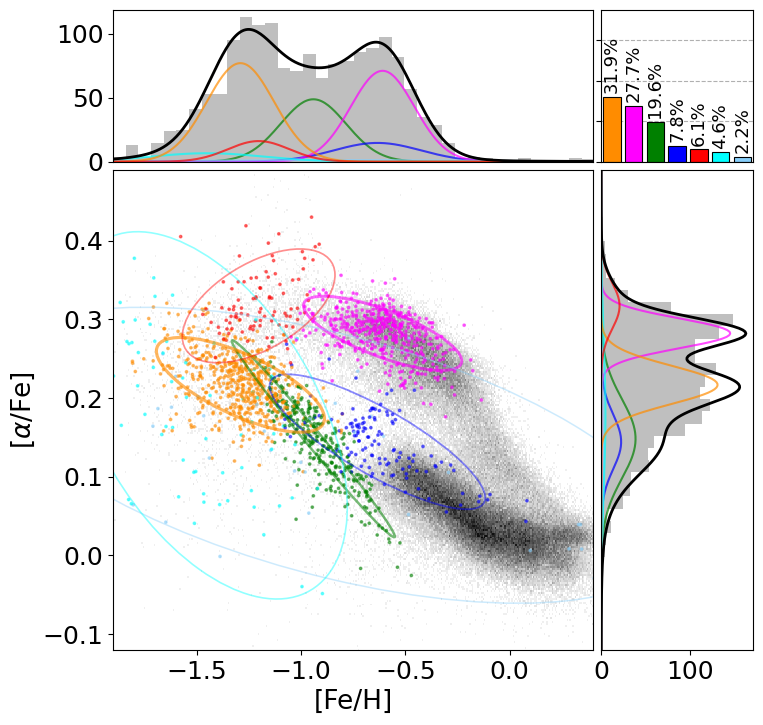

In [34]:
apogee_pipeline.plot_XD( x_key = 'fe_h', y_key='alpha_m',
    z_score=2,
    full_survey_file=background,
    color_palette=["green", "blue", "magenta", "lightskyblue", "cyan", "darkorange", "red"
    ], 
    xlim = (-1.9, 0.4), ylim=(-0.12, 0.49),
)

### **Result from [$\alpha$/Fe] vs [Fe/H]**
- Due to the APOGEE's lower metalicity popultation and the GS/E dominance of the population (51.6%) it has been able to distinguish between accreted population alpha plataeu (orange - denoted GS/E 2) and (green - denoted GS/E 1) knee.
- GS/E's low metalicity supports its ex-situ origin.
- Its $\alpha$ knees low metallicity at [Fe/H] $\approx -1.3/-1.2$ suggests weak star formation, further supported by the low [Al/Fe].
- Splashes high [$\alpha$/Fe] is expected as result of the orinate from the inner high alpha disk was enriched mainly by core-collapse supernovae (Type II) however `splashed` out before before the evolution of the Type Ia supernovae rebalancing
- The Aurora population has lowest metalicity and highest [$\alpha$/Fe] of all in-situ population, as it expected from the origin in the pre-disk (spin up) milky way.
- The Eos (a new population) position in between the high alpha sequence and the low alpha sequence - it is suggested to be associated with the Two Infall Model (from the GS/E merger) which brings with it less enrinched gas, diluting the ISM and resetting Fe/H to a lower baseline - consistent with simulation at the creation of outer (thin) disk. Helps shine light on the dichomotomy of the  [$\alpha$/Fe] - [Fe/H] plane

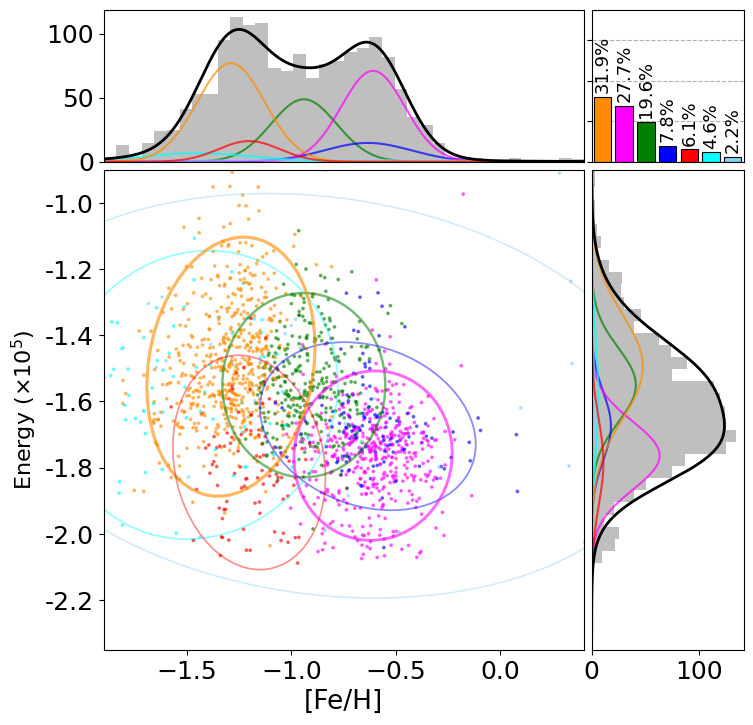

In [35]:
apogee_pipeline.plot_XD( x_key = 'fe_h', y_key='E_50',
    z_score=2,
    full_survey_file=background,
    color_palette=["green", "blue", "magenta", "lightskyblue", "cyan", "darkorange", "red"
    ], 
    xlim = (-1.9, 0.4), ylim=(-2.35e5, -0.9e5),
)

### **Result from Energy vs [Fe/H]**
- Both GS/E 1 and GS/E 2 populations show the highest mean energy with wide spread further support its ex situ origin, falling within the milky ways population.
- Splash low in Energy as it is an in situ populations, distrobuted and kicked out during GS/E merger.
- The Aurora population has the lowest energy of all distributions due to the kinematic properties of low spin from the pre disk state (ie see the evolution of $V_\phi$)

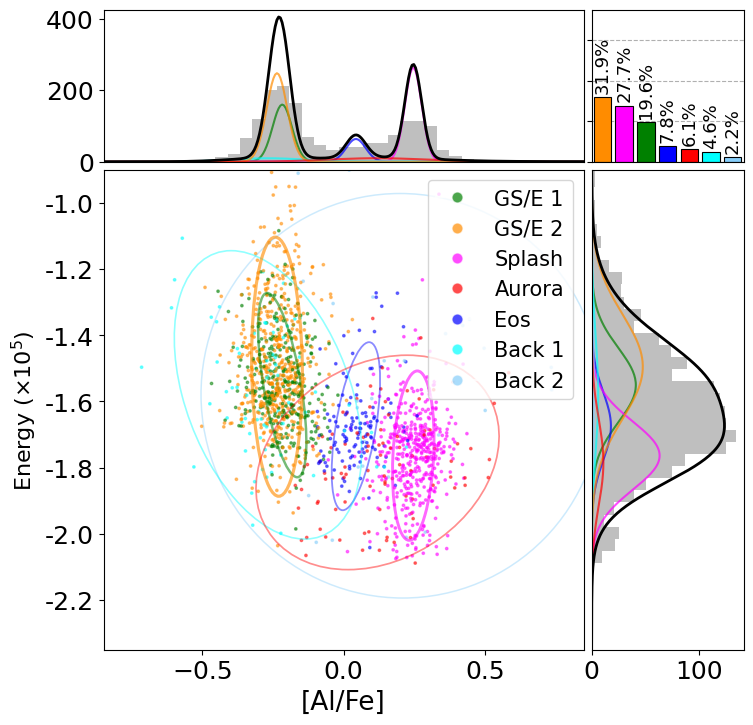

In [36]:
apogee_pipeline.plot_XD( x_key = 'al_fe', y_key='E_50',
    z_score=2,
    full_survey_file=background,
    color_palette=["green", "blue", "magenta", "lightskyblue", "cyan", "darkorange", "red"
    ], 
    xlim = (-0.85, 0.85), ylim=(-2.35e5, -0.9e5),
    legend=labels
)

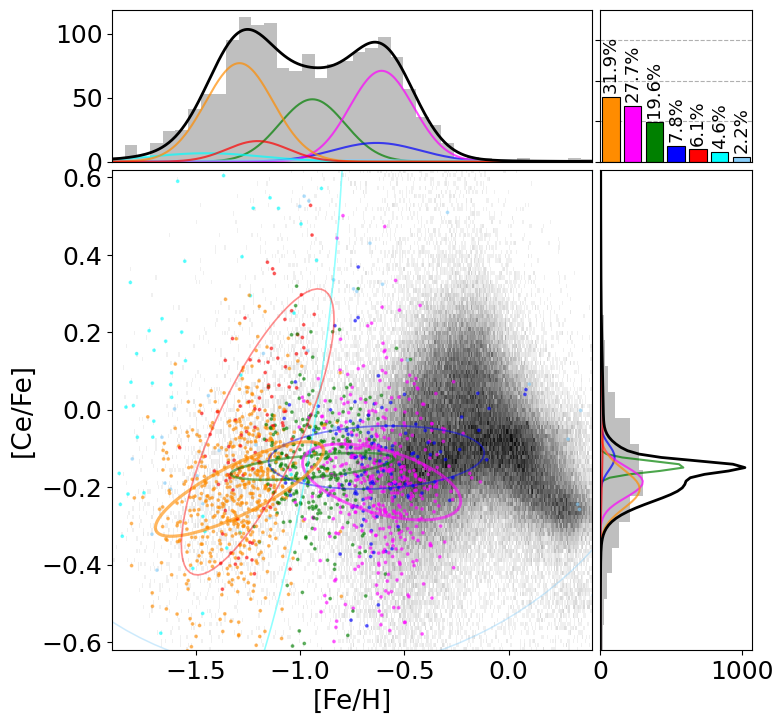

In [37]:
apogee_pipeline.plot_XD( x_key = 'fe_h', y_key='ce_fe',
    z_score=2,
    full_survey_file=background,
    color_palette=["green", "blue", "magenta", "lightskyblue", "cyan", "darkorange", "red"
    ], 
    xlim = (-1.9, 0.4), ylim=(-0.62, 0.62),
)

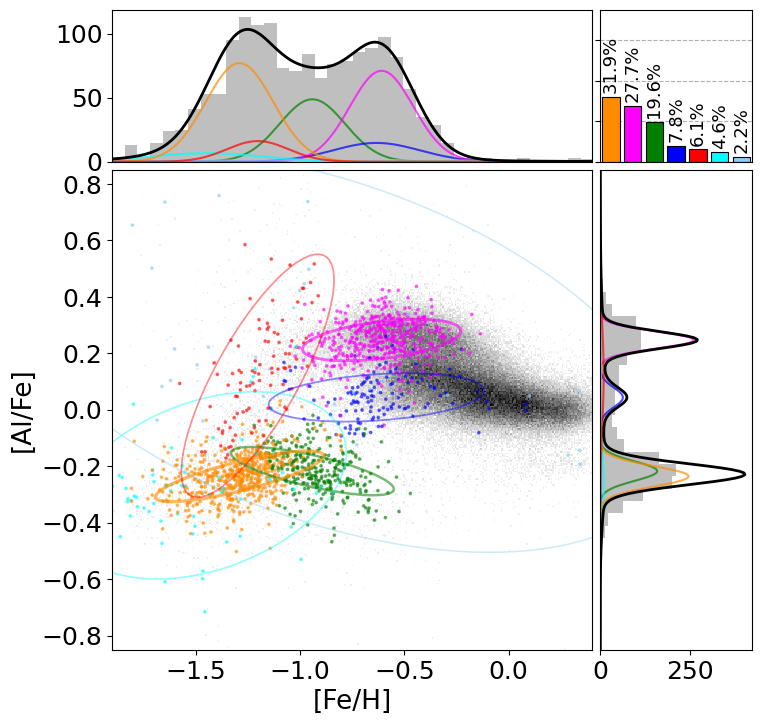

In [38]:
apogee_pipeline.plot_XD( x_key = 'fe_h', y_key='al_fe',
    z_score=2,
    full_survey_file=background,
    color_palette=["green", "blue", "magenta", "lightskyblue", "cyan", "darkorange", "red"
    ], 
    xlim = (-1.9, 0.4), ylim=(-0.85, 0.85),
)

### **Result from [Al/Fe] vs [Fe/H]**
- Al/Fe ratio evolves similiarly to that of Alpha elements, with it tracing out the relative contribution of Type II and Ia supernovae
- We see this distinction of the GS/E 1 and GS/E 2 population suggesting the GS/E 2 exists before the onset of SN Ia supernovae, with a steady increase in Al followed by the rebalancing and decreasing after their onset.
- We also see that the GS/E population globally is far lower mean in Al/Fe suggesting it was overall less efficient star forming dwarf galaxy than the milky way as expected

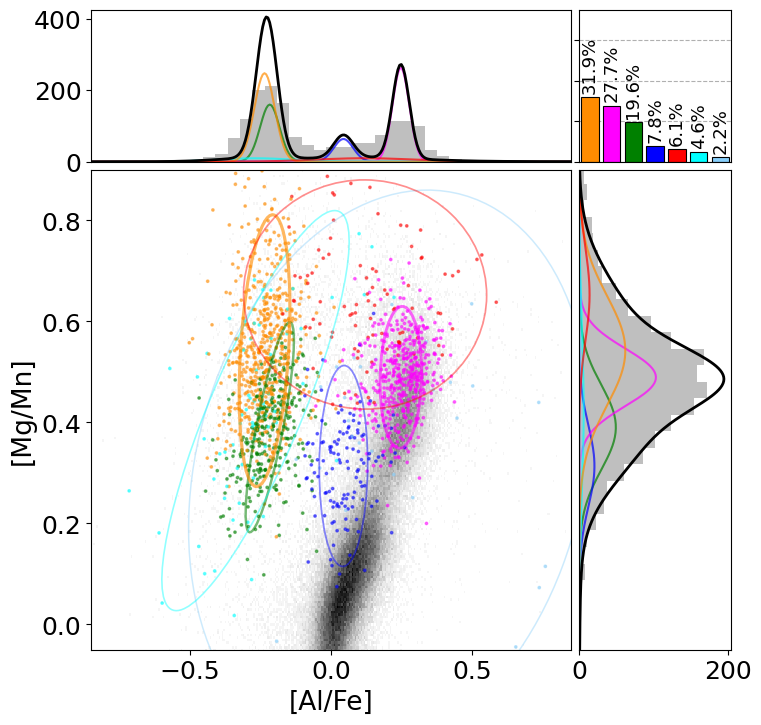

In [39]:
apogee_pipeline.plot_XD( x_key = 'al_fe', y_key='mg_mn',
    z_score=2,
    full_survey_file=background,
    color_palette=["green", "blue", "magenta", "lightskyblue", "cyan", "darkorange", "red"
    ], 
    xlim =(-0.85, 0.85), ylim=(-0.05, 0.9),
)

### Additional Plots for 7 Gaussian components are provided at the end of this Notebook


## **6 Gaussian Components**

- Here we similiar results to the above however the model has only create 1 background component
- It also rebalances the weighting between the decomposition of the GS/E merger, they actually flip in size, however there is great consistency between there combined properties (the only noticable difference is the 51.6% to 54.6% composition).

In [40]:
# Here i define the criteria and select the results which will be used - ie filter Gaussian = 5:
apogee_pipeline.compare_XD(opt_metric = 'BIC', n_gauss_filter = 6, repeat_no_filter = None, save_path='XD_Results/Apogee/apogee_XD_2_3_23.pkl', display_full=False)
# And then I preform the assignment:
apogee_pipeline.assigment_XD(assignment_metric = 'best filtered')


 The following filters were applied: {'n_gauss': 6, 'repeat': None}
 Best BIC Score from filtered inputs: 20264.6903 occurred at:
   - Gaussian Components (n_gauss): 6
   - Repeat cycle (n): 2
   - Initialisation (i): 87
Assigning stars to Gaussian components based on the best filtered XD model.
This has been optimised for the BIC score and returned the results:
 Best BIC Score: 20264.6903 occurred at:
   - Gaussian Components (n_gauss): 6
   - Repeat cycle (n): 2
   - Initialisation (i): 87


In [41]:
# I now summarise the Gaussian Component results in a table:
labels = {
    4: "GS/E 1",
    3: "GS/E 2",
    0: "Splash",
    5: "Aurora",
    1: "Eos",
    2: "Background"
}

apogee_gauss_summary = apogee_pipeline.table_results_XD(labels, combine=[[3, 4]], labels_combined = ['GS/E'])


Summary of GMM Fit Result for GALAH-Gaia Sample
+----+-------------+--------------+---------+-------------+--------------+-------------+---------------------------------+--------------+--------------+-------------+
|    | Component   |   Weight (%) |   Count |   Count (%) | fe_h         | alpha_m     | Scaled Energy ($\times 10^5$)   | ce_fe        | al_fe        | mg_mn       |
+====+=============+==============+=========+=============+==============+=============+=================================+==============+==============+=============+
|  0 | GS/E 1      |         35   |     582 |        36.1 | -1.05 ± 0.20 | 0.17 ± 0.05 | -154030.47 ± 12161.23           | -0.16 ± 0.02 | -0.21 ± 0.03 | 0.44 ± 0.10 |
+----+-------------+--------------+---------+-------------+--------------+-------------+---------------------------------+--------------+--------------+-------------+
|  1 | GS/E 2      |         19.6 |     303 |        18.8 | -1.39 ± 0.17 | 0.22 ± 0.03 | -148770.73 ± 18441.55      

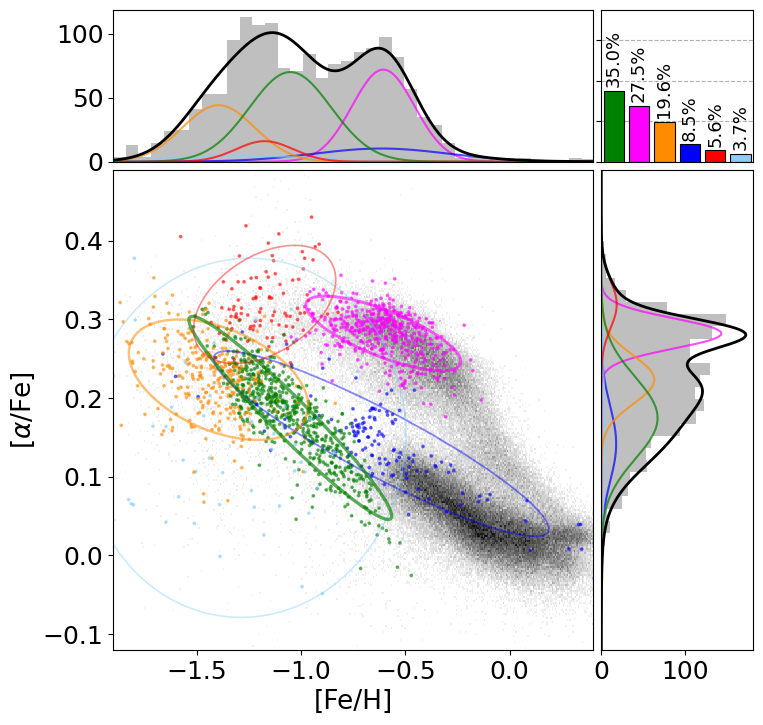

In [42]:
apogee_pipeline.plot_XD( x_key = 'fe_h', y_key='alpha_m',
    z_score=2,
    full_survey_file=background,
    color_palette=["magenta", "blue", "lightskyblue", "darkorange", "green", "red"
    ], 
    xlim = (-1.9, 0.4), ylim=(-0.12, 0.49),
)

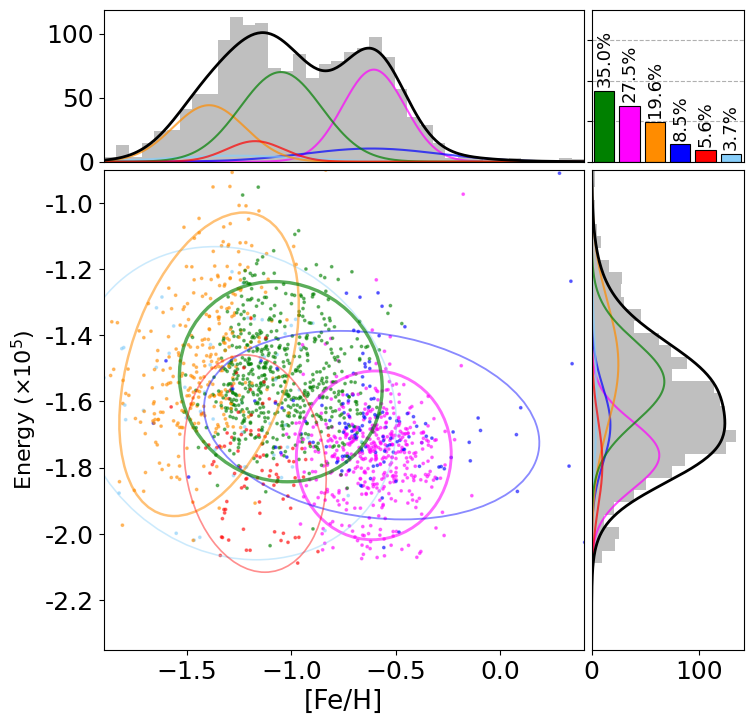

In [43]:
apogee_pipeline.plot_XD( x_key = 'fe_h', y_key='E_50',
    z_score=2,
    full_survey_file=background,
    color_palette=["magenta", "blue", "lightskyblue", "darkorange", "green", "red"
    ],  
    xlim = (-1.9, 0.4), ylim=(-2.35e5, -0.9e5),
)

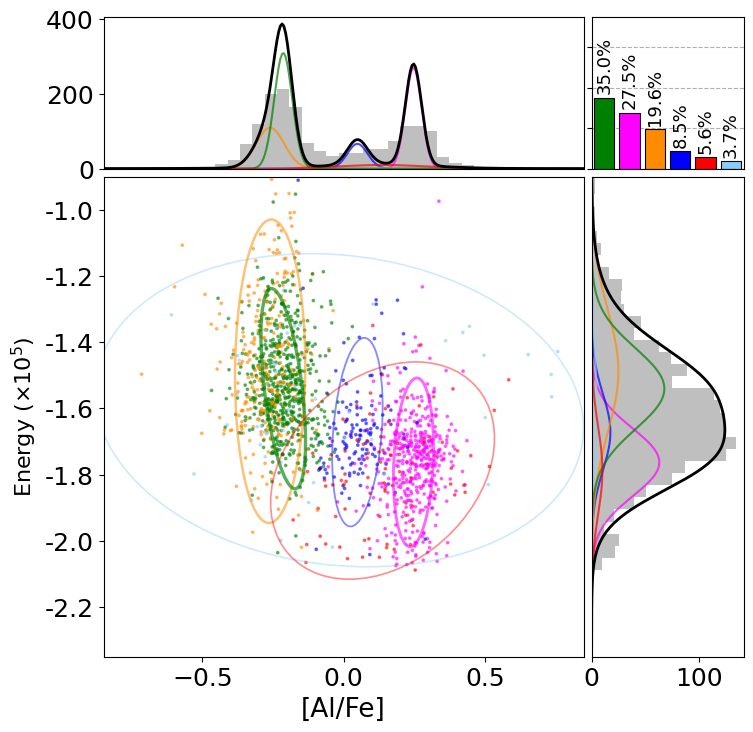

In [44]:
apogee_pipeline.plot_XD( x_key = 'al_fe', y_key='E_50',
    z_score=2,
    full_survey_file=background,
    color_palette=["magenta", "blue", "lightskyblue", "darkorange", "green", "red"
    ],  
    xlim = (-0.85, 0.85), ylim=(-2.35e5, -0.9e5),
)

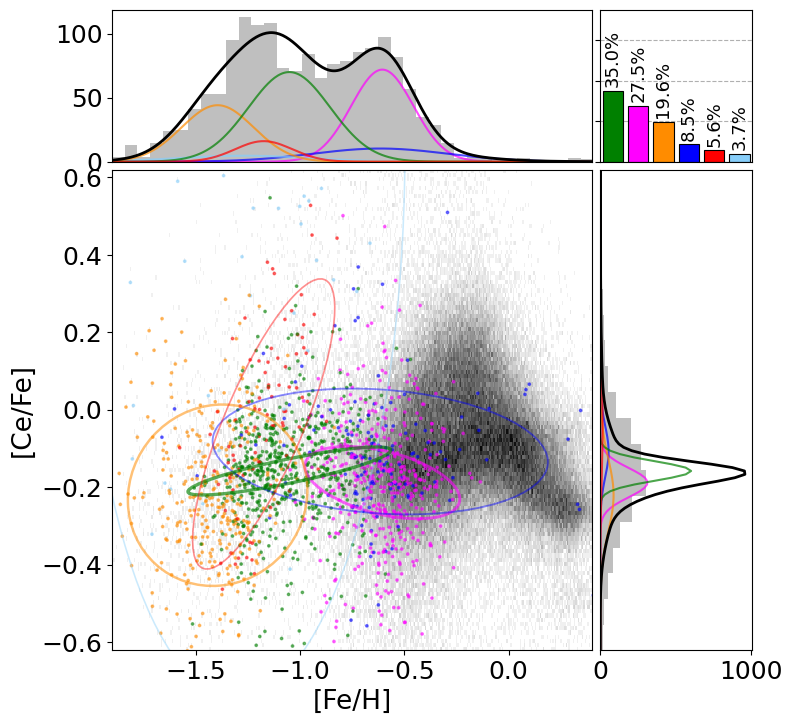

In [45]:
apogee_pipeline.plot_XD( x_key = 'fe_h', y_key='ce_fe',
    z_score=2,
    full_survey_file=background,
    color_palette=["magenta", "blue", "lightskyblue", "darkorange", "green", "red"
    ],  
    xlim = (-1.9, 0.4), ylim=(-0.62, 0.62),
)

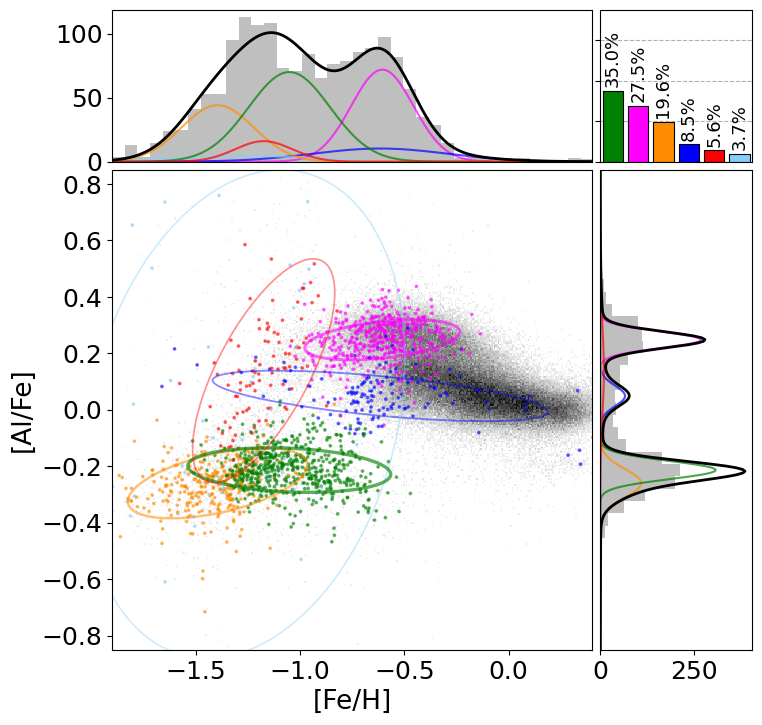

In [46]:
apogee_pipeline.plot_XD( x_key = 'fe_h', y_key='al_fe',
    z_score=2,
    full_survey_file=background,
    color_palette=["magenta", "blue", "lightskyblue", "darkorange", "green", "red"
    ],  
    xlim = (-1.9, 0.4), ylim=(-0.85, 0.85),
)

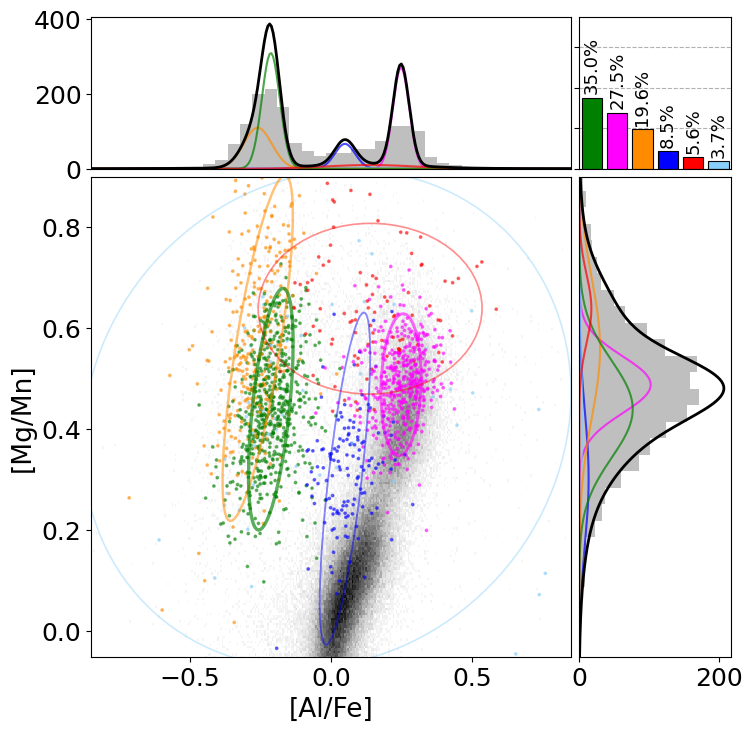

In [47]:
apogee_pipeline.plot_XD( x_key = 'al_fe', y_key='mg_mn',
    z_score=2,
    full_survey_file=background,
    color_palette=["magenta", "blue", "lightskyblue", "darkorange", "green", "red"
    ],  
    xlim =(-0.85, 0.85), ylim=(-0.05, 0.9),
)

## **5 Gaussian Components**

- Here we similiar results to the above however the model has only create 1 background component and we loose the Aurora gaussian.
- It also rebalances the weighting between the decomposition of the GS/E merger, they actually flip in size, however there is great consistency between there combined properties (the only noticable difference is the 51.6% to 56.1% composition (comparison with 7 Gausian Components)).


In [48]:
# Here i define the criteria and select the results which will be used - ie filter Gaussian = 5:
apogee_pipeline.compare_XD(opt_metric = 'BIC', n_gauss_filter = 5, repeat_no_filter = None, save_path='XD_Results/Apogee/apogee_XD_2_3_23.pkl', display_full=False)
# And then I preform the assignment:
apogee_pipeline.assigment_XD(assignment_metric = 'best filtered')

 The following filters were applied: {'n_gauss': 5, 'repeat': None}
 Best BIC Score from filtered inputs: 20257.9314 occurred at:
   - Gaussian Components (n_gauss): 5
   - Repeat cycle (n): 2
   - Initialisation (i): 7
Assigning stars to Gaussian components based on the best filtered XD model.
This has been optimised for the BIC score and returned the results:
 Best BIC Score: 20257.9314 occurred at:
   - Gaussian Components (n_gauss): 5
   - Repeat cycle (n): 2
   - Initialisation (i): 7


In [49]:
# I now summarise the Gaussian Component results in a table:
labels = {
    0: "GS/E 1",
    1: "GS/E 2",
    2: "Splash",
    4: "Eos",
    3: "Background"
}

apogee_gauss_summary = apogee_pipeline.table_results_XD( labels, combine=[[0, 1]], labels_combined = ['GS/E'])


Summary of GMM Fit Result for GALAH-Gaia Sample
+----+-------------+--------------+---------+-------------+--------------+-------------+---------------------------------+--------------+--------------+-------------+
|    | Component   |   Weight (%) |   Count |   Count (%) | fe_h         | alpha_m     | Scaled Energy ($\times 10^5$)   | ce_fe        | al_fe        | mg_mn       |
+====+=============+==============+=========+=============+==============+=============+=================================+==============+==============+=============+
|  0 | GS/E 1      |         35   |     573 |        35.5 | -1.05 ± 0.19 | 0.17 ± 0.05 | -151415.79 ± 13650.98           | -0.15 ± 0.02 | -0.22 ± 0.03 | 0.43 ± 0.09 |
+----+-------------+--------------+---------+-------------+--------------+-------------+---------------------------------+--------------+--------------+-------------+
|  1 | GS/E 2      |         21.1 |     335 |        20.8 | -1.39 ± 0.17 | 0.23 ± 0.04 | -155952.76 ± 17728.26      

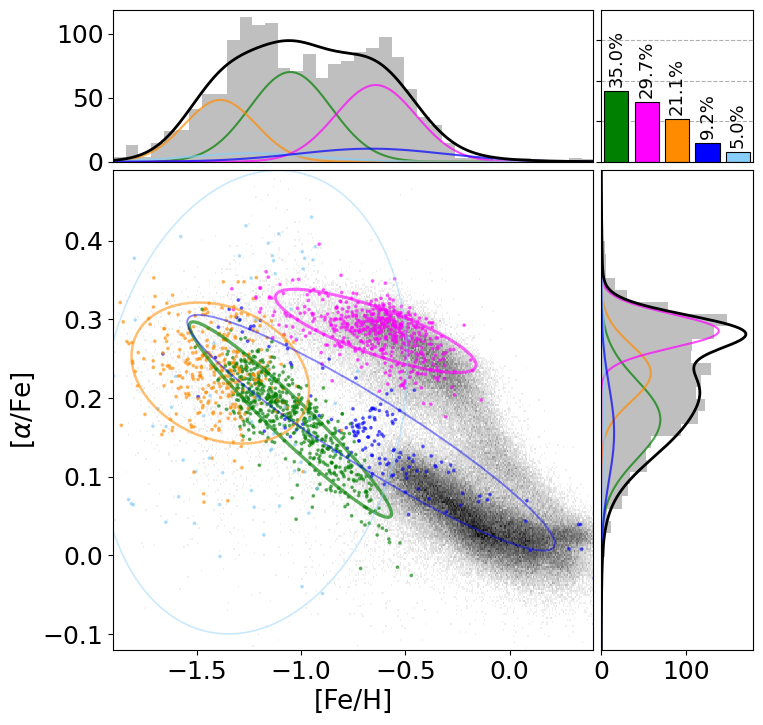

In [50]:
apogee_pipeline.plot_XD( x_key = 'fe_h', y_key='alpha_m',
    z_score=2,
    full_survey_file=background,
    color_palette=["green", "darkorange", "magenta", "lightskyblue", "blue"
    ], 
    xlim = (-1.9, 0.4), ylim=(-0.12, 0.49),
)

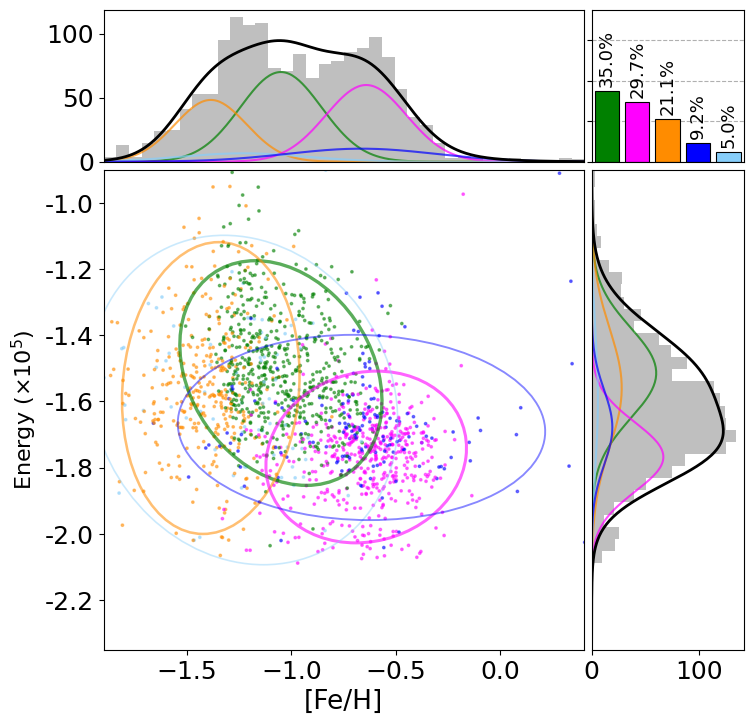

In [51]:
apogee_pipeline.plot_XD( x_key = 'fe_h', y_key='E_50',
    z_score=2,
    full_survey_file=background,
    color_palette=["green", "darkorange", "magenta", "lightskyblue", "blue"
    ], 
    xlim = (-1.9, 0.4), ylim=(-2.35e5, -0.9e5),
)

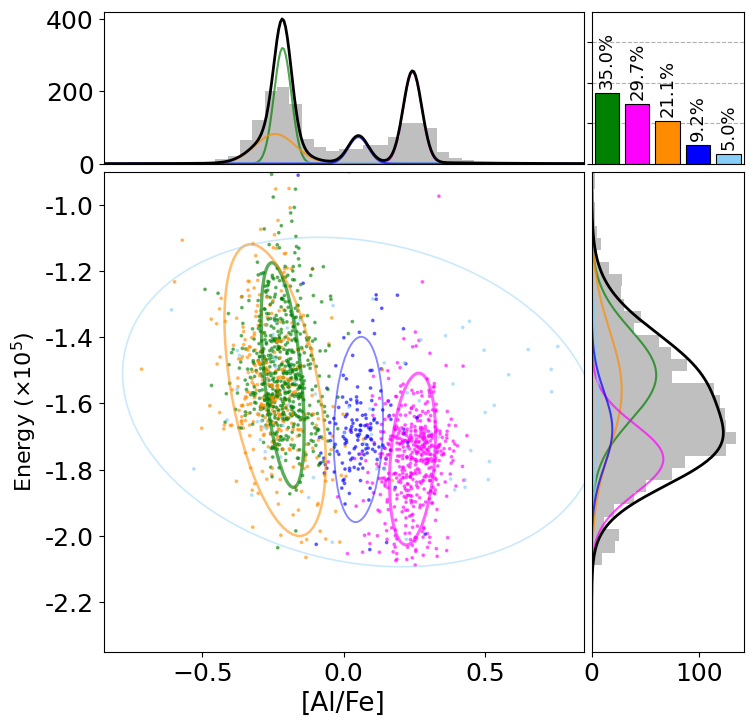

In [52]:
apogee_pipeline.plot_XD( x_key = 'al_fe', y_key='E_50',
    z_score=2,
    full_survey_file=background,
    color_palette=["green", "darkorange", "magenta", "lightskyblue", "blue"
    ],  
    xlim = (-0.85, 0.85), ylim=(-2.35e5, -0.9e5),
)

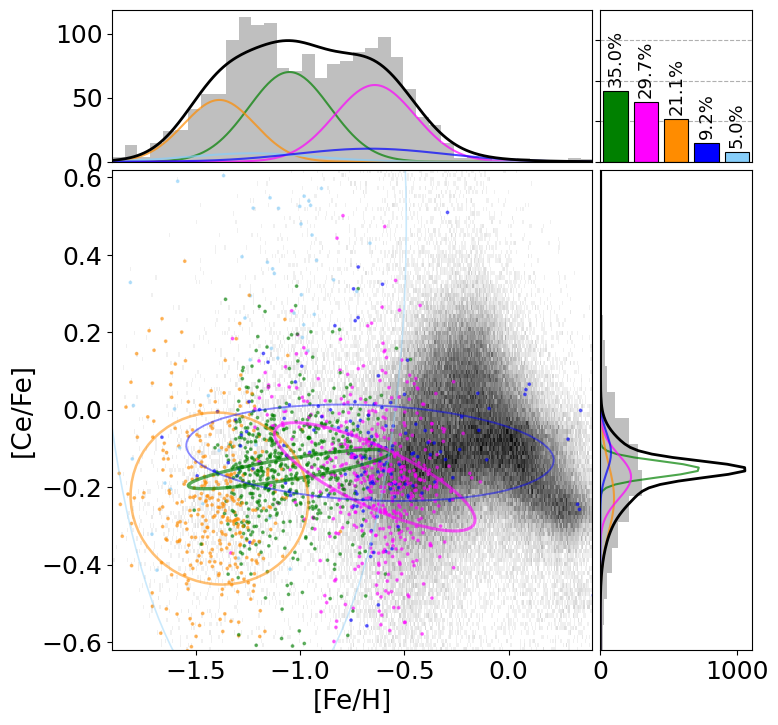

In [53]:
apogee_pipeline.plot_XD( x_key = 'fe_h', y_key='ce_fe',
    z_score=2,
    full_survey_file=background,
    color_palette=["green", "darkorange", "magenta", "lightskyblue", "blue"
    ],  
    xlim = (-1.9, 0.4), ylim=(-0.62, 0.62),
)

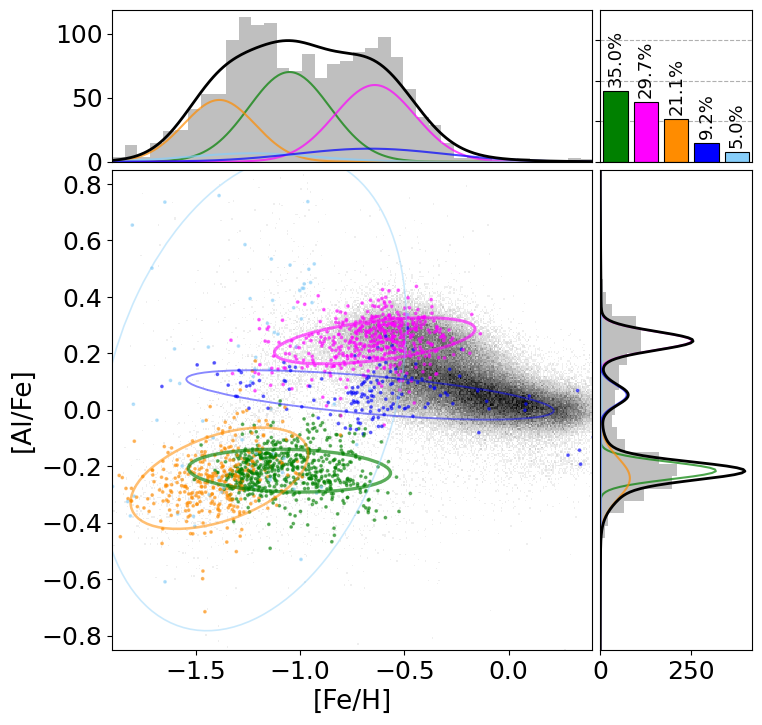

In [54]:
apogee_pipeline.plot_XD( x_key = 'fe_h', y_key='al_fe',
    z_score=2,
    full_survey_file=background,
    color_palette=["green", "darkorange", "magenta", "lightskyblue", "blue"
    ], 
    xlim = (-1.9, 0.4), ylim=(-0.85, 0.85),
)

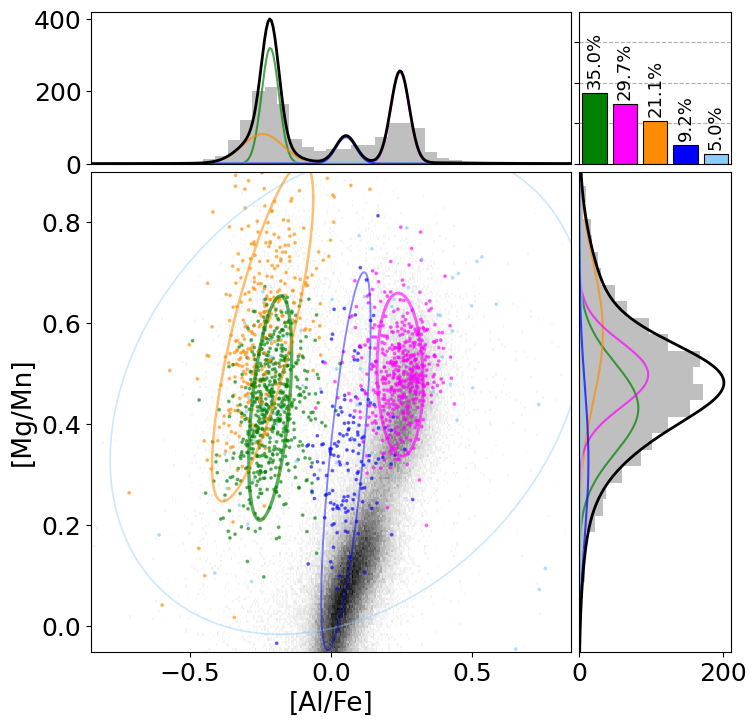

In [55]:
apogee_pipeline.plot_XD( x_key = 'al_fe', y_key='mg_mn',
    z_score=2,
    full_survey_file=background,
    color_palette=["green", "darkorange", "magenta", "lightskyblue", "blue"
    ],  
    xlim =(-0.85, 0.85), ylim=(-0.05, 0.9),
)

## Returning to **7 Gaussian Components**
## Figure 5 Plots

In [56]:
# Here i define the criteria and select the results which will be used - ie filter Gaussian = 5:
apogee_pipeline.compare_XD(opt_metric = 'BIC', n_gauss_filter = 7, repeat_no_filter = None, save_path='XD_Results/Apogee/apogee_XD_2_3_23.pkl', display_full=False)
# And then I preform the assignment:
apogee_pipeline.assigment_XD(assignment_metric = 'best filtered')

 The following filters were applied: {'n_gauss': 7, 'repeat': None}
 Best BIC Score from filtered inputs: 20337.4275 occurred at:
   - Gaussian Components (n_gauss): 7
   - Repeat cycle (n): 2
   - Initialisation (i): 73
Assigning stars to Gaussian components based on the best filtered XD model.
This has been optimised for the BIC score and returned the results:
 Best BIC Score: 20337.4275 occurred at:
   - Gaussian Components (n_gauss): 7
   - Repeat cycle (n): 2
   - Initialisation (i): 73


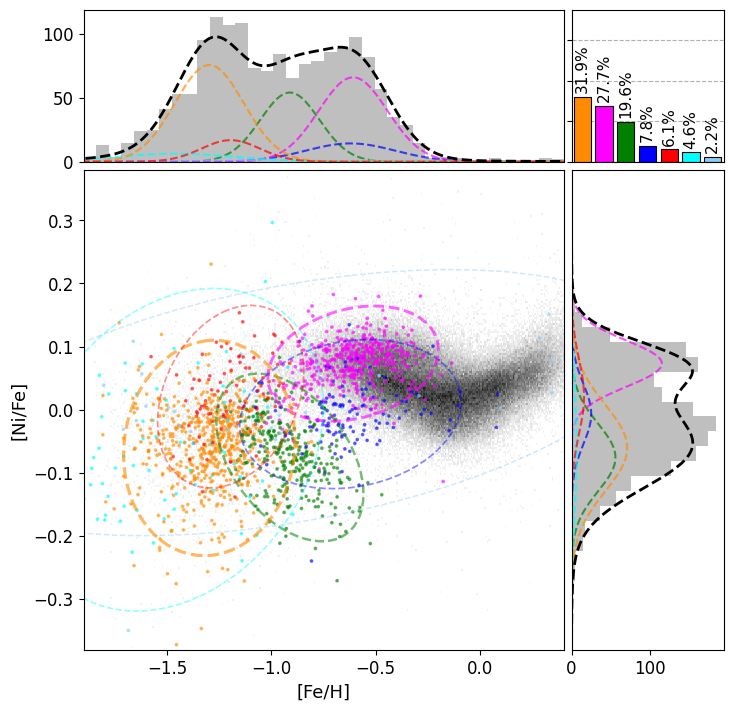

In [57]:
apogee_pipeline.plot_nonXD( x_key = 'fe_h', y_key='ni_fe',
    z_score=2,
    full_survey_file=background,
    color_palette=["green", "blue", "magenta", "lightskyblue", "cyan", "darkorange", "red"
    ], 
    xlim =(-1.9, 0.4), ylim=(-0.38, 0.38),
)